In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')

from codes.docs.analysis import data_preprocessing, genetic_file_preprocess
from codes.docs.analysis.nimagen import genes, stats, visualisation

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.io
import glob
from collections import defaultdict
%matplotlib inline

In [2]:
european_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

In [3]:
european_term = european_term[~european_term['available_dmri'].isna()]

In [4]:
european_term = european_term.drop_duplicates(subset=['ID'],keep='first')

In [5]:
#to use in FBA we need to transform ID and Session to sub- and ses-
# european_term['ID'] =  'sub-' + european_term['ID']
# european_term['Session'] =  'ses-' + european_term['Session'].astype('str')
european_term['ID/Session'] = 'sub-' + european_term['ID'] +'/'+'ses-' + european_term['Session'].astype('str')

In [6]:
european_term['ID/Session'].to_csv('../../codes/FBA/all_european_term.txt',header=None,index=False)

In [7]:
to_exclude=['sub-CC01105XX08/ses-99330','sub-CC00545XX18/ses-170400'] # bad mask

In [8]:
european_term = european_term[~european_term['ID/Session'].isin(to_exclude)]

In [9]:
#we remove outliers related to ancestry
df = european_term.copy()

ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers

df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)



#divide into high and low risk in three quarters

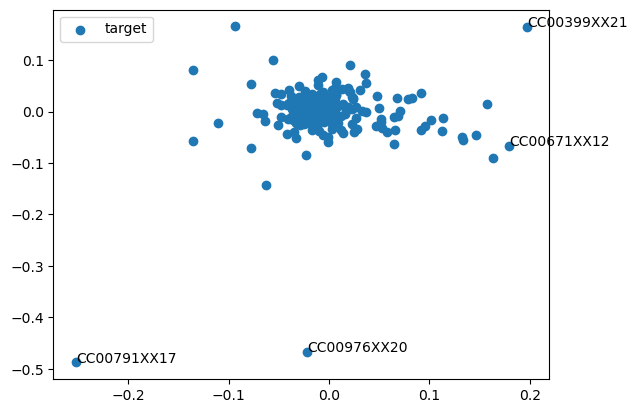

In [10]:
_ , _ = genetic_file_preprocess.Cohort.remove_outliers(
    european_term,
    to_examine=['euro_Anc_PC2', 'euro_Anc_PC3'],
    to_annotate='ID')

In [84]:
allele_C = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/APOE/dHCP_rs429358.raw')
allele_T = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/APOE/dHCP_rs7412.raw')

In [85]:
allele_C=allele_C[['ID','19:45411941_C']]
allele_T=allele_T[['ID','19:45412079_T']]

In [86]:
apoe_genotype = allele_C.merge(allele_T)

In [87]:
apoe_genotype.columns = ['ID','codon112','codon158']

In [88]:
apoe_genotype = apoe_genotype.dropna()

In [89]:
apoe_genotype['codon112'] = apoe_genotype['codon112'].astype('int64')
apoe_genotype['codon158'] = apoe_genotype['codon158'].astype('int64')

In [104]:
apoe_genotype['genotype'] = ['e3/e3' if (codon112==0 and codon158==0) or (codon112==2 and codon158==2) 
                             else 'e2/e3' if (codon112==0 and codon158==1) or (codon112==1 and codon158==2) 
                             else 'e2/e2' if (codon112==0 and codon158==2) 
                             else 'e3/e4' if (codon112==1 and codon158==0) or (codon112==2 and codon158==1) 
                             else 'e2/e4' if (codon112==1 and codon158==1) 
                             else 'e4/e4' for codon112,codon158 in apoe_genotype[['codon112','codon158']].itertuples(index=False,name=None)]

In [110]:
apoe_genotype[apoe_genotype['genotype'] == 'e3/e4']

,ID,codon112,codon158,genotype
4,CC00037XX13,1,0,e3/e4
9,CC00056XX07,1,0,e3/e4
18,CC00064XX07,1,0,e3/e4
20,CC00066XX09,1,0,e3/e4
21,CC00067XX10,1,0,e3/e4
...,...,...,...,...
799,CC01206XX10,1,0,e3/e4
800,CC01207XX11,1,0,e3/e4
803,CC01211XX07,1,0,e3/e4
809,CC01232AN12,1,0,e3/e4


In [113]:
df = df.merge(apoe_genotype,on=['ID'])

In [121]:

df.genotype.value_counts()

e3/e3    136
e3/e4     53
e2/e3     32
e4/e4      5
e2/e4      2
e2/e2      1
Name: genotype, dtype: int64

In [122]:
df['carrier'] = ['carrier' if 'e4' in i else 'non-carrier' for i in df.genotype]

In [126]:
df['carrier'].value_counts()

non-carrier    169
carrier         60
Name: carrier, dtype: int64

In [128]:
df[['ID/Session','sex','PMA','GA','ICV','TBV','carrier']+[f'euro_Anc_PC{i}' for i in range(1,4)]].to_csv('../../codes/FBA/available_subjects_APOE.txt',header=None,index=False)